In [39]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Load your data
data = pd.read_csv('data.csv')
data = data.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, replace non-numeric with NaN
data = data.dropna()  # Drop rows with NaN values
data = data.values


In [41]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, seq_length, num_heads, num_layers, dim_feedforward):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_size,
            nhead=num_heads,
            dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size * seq_length, input_size)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

In [42]:
def train_model(model, dataloader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}')

# Assuming `data` is your time series data in numpy array
seq_length = 10
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# Prepare dataset and dataloader
dataset = TimeSeriesDataset(data, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
input_size = data.shape[1]  # Number of products (columns)
model = TimeSeriesTransformer(input_size=input_size, seq_length=seq_length, num_heads=2, num_layers=2, dim_feedforward=128)

# Train the model
train_model(model, dataloader, num_epochs, learning_rate)

c:\Users\davi8\.conda\envs\ml\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/50, Loss: 8745682.7778
Epoch 2/50, Loss: 8678670.7593
Epoch 3/50, Loss: 8699902.9815
Epoch 4/50, Loss: 8596084.1852
Epoch 5/50, Loss: 8508758.1111
Epoch 6/50, Loss: 8427192.7778
Epoch 7/50, Loss: 8349322.3519
Epoch 8/50, Loss: 8293283.5926
Epoch 9/50, Loss: 8176260.7037
Epoch 10/50, Loss: 8018614.5556
Epoch 11/50, Loss: 7969149.9074
Epoch 12/50, Loss: 7769957.0926
Epoch 13/50, Loss: 7661424.5926
Epoch 14/50, Loss: 7528192.8148
Epoch 15/50, Loss: 7389292.5926
Epoch 16/50, Loss: 7264288.1667
Epoch 17/50, Loss: 7098394.3889
Epoch 18/50, Loss: 6940021.8704
Epoch 19/50, Loss: 6822015.6481
Epoch 20/50, Loss: 6623897.0556
Epoch 21/50, Loss: 6445556.3704
Epoch 22/50, Loss: 6302590.1667
Epoch 23/50, Loss: 6145282.3704
Epoch 24/50, Loss: 5980907.6111
Epoch 25/50, Loss: 5774782.0926
Epoch 26/50, Loss: 5596223.9074
Epoch 27/50, Loss: 5444924.8519
Epoch 28/50, Loss: 5334233.3519
Epoch 29/50, Loss: 5149226.3333
Epoch 30/50, Loss: 4973834.6574
Epoch 31/50, Loss: 4825885.1019
Epoch 32/50, Loss

In [59]:
def predict(model, input_seq):
    model.eval()
    with torch.no_grad():
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        input_seq = input_seq.unsqueeze(0)  # Add batch dimension
        prediction = model(input_seq)
    return prediction.squeeze(0).numpy()

# Example of using the model for prediction
test_input = data[-seq_length:]  # Last sequence in your data
""""
test_input = [ 882.4191, 2178.926,  1448.0823 ,1583.7012, 2060.3618, 2072.6284, 1952.2611,
 1517.5466, 1290.2137, 1827.1056, 1426.8905, 1498.3647, 2211.351,  1668.3501,
 2219.3577, 1655.0233, 1872.1208, 1868.3329, 2126.0857, 1824.7427, 2128.9658,
 2292.6055, 2022.8518, 2087.3438, 1277.3455, 1335.0608, 1594.757,  1908.9077,
 1699.9355, 1828.1053]"""
print(test_input)
predicted_output = predict(model, test_input)
print(predicted_output)

[[ 875. 5700. 3733. 1875. 5867. 5867. 2467. 1378. 1280. 4405. 1767. 3033.
  2267. 2267. 7778. 2242.  879.  879. 5667. 2879. 1845. 7281. 2900. 6167.
  1833. 1675. 2500. 3333. 2389. 2200.]
 [ 917. 4867. 3467. 1958. 5933. 5933. 2600. 1467. 1173. 4107. 1667. 2767.
  5000. 2300. 2167. 2167.  932.  932. 5333. 3030. 1905. 7281. 2900. 6067.
  1833. 1550. 2556. 3667. 2111. 2300.]
 [ 938. 4733. 2725. 1917. 5800. 5800. 2733. 1378. 1080. 4196. 1267. 2567.
  4833. 2250. 8444. 2443.  955.  955. 5267. 2879. 1726. 7105. 2933. 6167.
  1867. 1550. 3667. 3667. 1778. 2350.]
 [ 938. 5800. 2867. 1944. 5733. 5733. 2733. 1422. 1040. 3929. 1280. 2700.
  2250. 2250. 8556. 2424.  939.  939. 5333. 2955. 1643. 7171. 3050. 6067.
  1833. 1567. 2611. 3333. 2028. 2433.]
 [ 958. 5850. 3267. 1944. 5667. 5667. 2773. 1511. 1107. 3690. 1233. 2567.
  4933. 2300. 8111. 2424.  909.  909. 5267. 3030. 1667. 7456. 3350. 5333.
  1767. 1325. 2644. 3360. 2222. 2433.]
 [ 979. 5533. 3233. 1889. 5533. 5533. 2667. 1800. 1360. 3524. 113

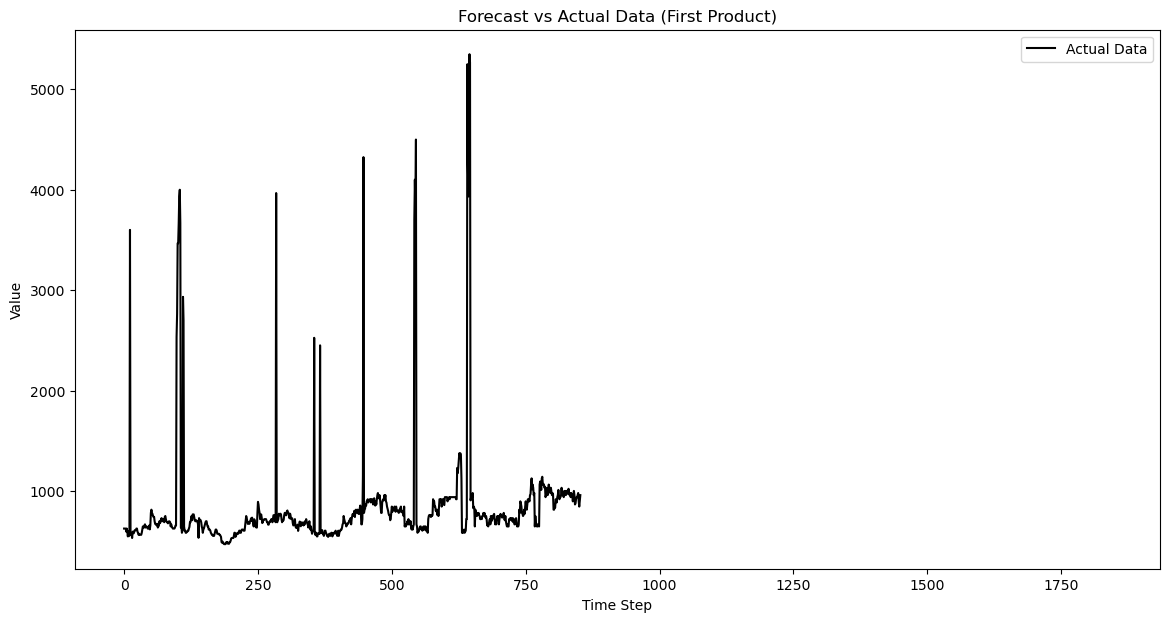

In [53]:
import matplotlib.pyplot as plt
import numpy as np
def predict(model, input_seq):
    model.eval()
    with torch.no_grad():
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        input_seq = input_seq.unsqueeze(0)  # Add batch dimension
        prediction = model(input_seq)
    return prediction.squeeze(0).numpy()

# Prepare the data for plotting
def plot_forecast(data, model, seq_length, num_forecasts=1000):
    # Generate predictions for the last `num_forecasts` sequences
    predictions = []
    actuals = data[-seq_length:]  # The last sequence in your data

    for _ in range(num_forecasts):
        pred = predict(model, actuals)
        predictions.append(pred[0])  # Only the first channel
        actuals = np.concatenate((actuals[1:], pred[None, :]), axis=0)
    # Plot the results
    plt.figure(figsize=(14, 7))
    
    # Plot the actual data
    plt.plot(range(len(data)), data[:, 0], color='black', label='Actual Data')

    # Plot the forecasted data
    for i, pred in enumerate(predictions):
        plt.plot(range(len(data) - seq_length + i, len(data) - seq_length + i + 1), pred, color=plt.cm.viridis(i / num_forecasts))

    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Forecast vs Actual Data (First Product)')
    plt.legend()
    plt.show()

# Example of using the plot function
plot_forecast(data, model, seq_length)

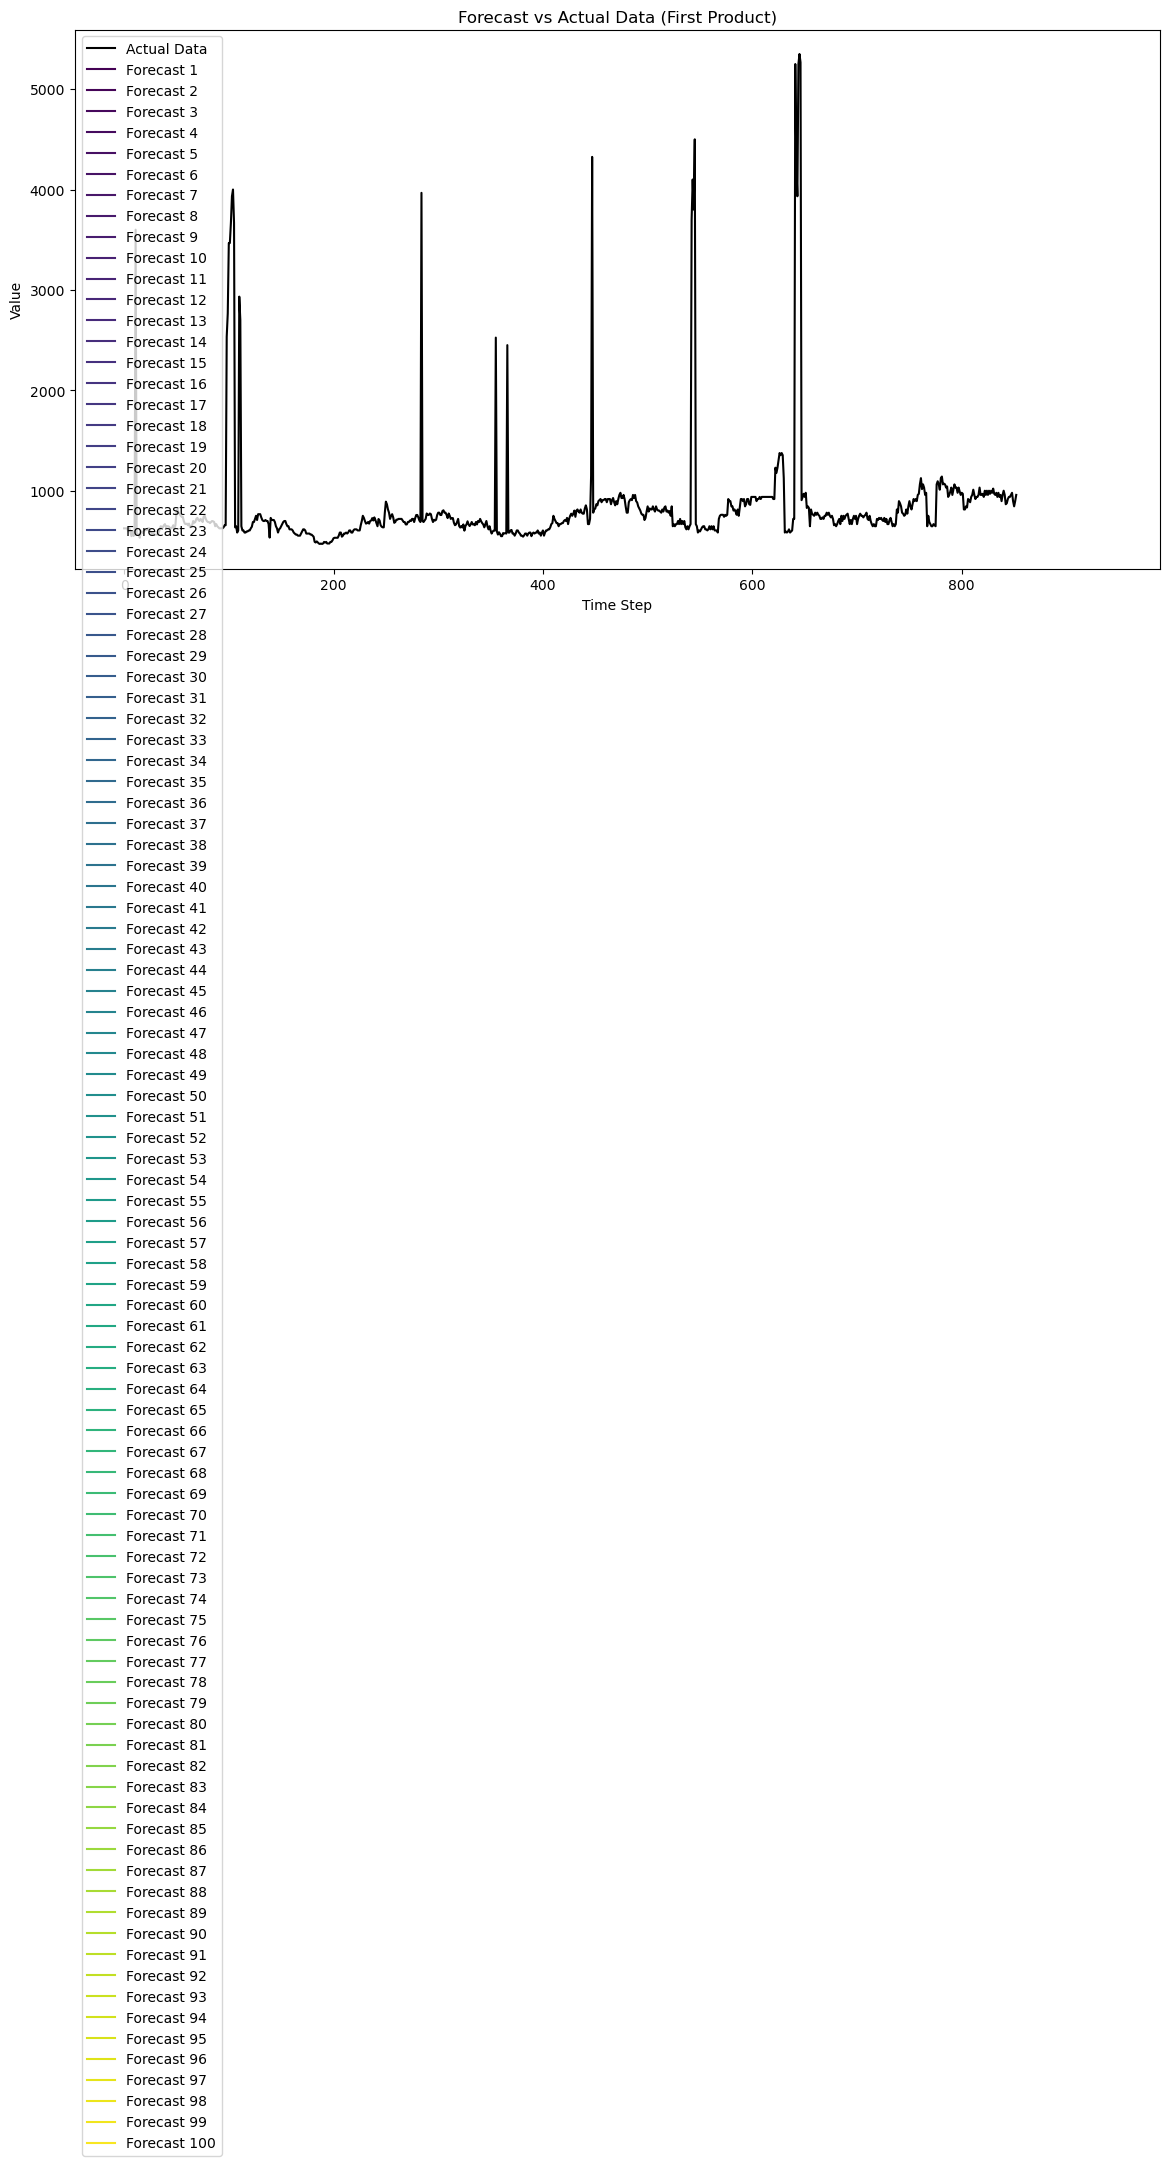

In [55]:
import matplotlib.pyplot as plt

def predict(model, input_seq):
    model.eval()
    with torch.no_grad():
        input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        prediction = model(input_seq)
    return prediction.squeeze(0).numpy()  # Remove batch dimension

def plot_forecast(data, model, seq_length, num_forecasts=100):
    predictions = []
    actuals = data[-seq_length:]  # The last sequence in your data

    for _ in range(num_forecasts):
        pred = predict(model, actuals)
        predictions.append(pred[0])  # Only the first channel
        actuals = np.concatenate((actuals[1:], pred[None, :]), axis=0)  # Update the sequence

    plt.figure(figsize=(14, 7))
    
    # Plot the actual data
    plt.plot(range(len(data)), data[:, 0], color='black', label='Actual Data')

    # Plot the forecasted data
    forecast_start = len(data) - seq_length
    for i, pred in enumerate(predictions):
        plt.plot(range(forecast_start + i, forecast_start + i + 1), pred, color=plt.cm.viridis(i / num_forecasts), label=f'Forecast {i+1}')

    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Forecast vs Actual Data (First Product)')
    plt.legend()
    plt.show()

# Example of using the plot function
plot_forecast(data, model, seq_length)

In [ ]:
data

,Ahuyama,Arveja verde en vaina,Cebolla cabezona blanca,Cebolla junca,Chocolo mazorca,Fríjol verde*,Habichuela,Lechuga batavia,Pepino cohombro,Pimentón,...,Mango tommy,Manzana royal gala,Maracuyá,Mora de Castilla,Naranja*,Papaya maradol,Piña *,Tomate de árbol,Arracacha*,Plátano hartón verde
0,625.0,3900.0,558.0,867.0,1330.0,3000.0,1740.0,1517.0,640.0,2786.0,...,1591.0,4211.0,3050.0,3750.0,783.0,1088.0,800.0,1630.0,1250.0,1250.0
1,625,3833.0,550.0,783.0,1600,3050,1483.0,1458.0,600.0,2679.0,...,1591,4211.0,3000.0,3750.0,800,1194.0,783.0,1587.0,1333.0,1250.0
2,625.0,3900.0,470.0,833.0,1200.0,2800.0,1600.0,1600.0,640.0,2857.0,...,1591.0,4342.0,2433.0,730.0,730.0,1167.0,1739.0,1739.0,1350.0,1350.0
3,625.0,4700.0,400.0,900.0,1450.0,3050.0,1683.0,1600.0,600.0,2500.0,...,1496.0,4474.0,2375.0,660.0,660.0,1278.0,706.0,1891.0,1333.0,1442.0
4,594,4700.0,430.0,917.0,1358,3117,1980.0,1550.0,600.0,2440.0,...,1523,4474.0,2500.0,3000.0,680,1361.0,700.0,1913.0,1000.0,1350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,979.0,5533.0,3233.0,1889.0,5533.0,5533.0,2667.0,1800.0,1360.0,3524.0,...,1762.0,7632.0,3533.0,5333.0,1833.0,1275.0,2583.0,3267.0,2194.0,2467.0
852,896.0,4867.0,2633.0,1917.0,5133.0,5133.0,2800.0,1911.0,1253.0,2976.0,...,2381.0,7193.0,3433.0,5167.0,1813.0,1233.0,2667.0,3173.0,2111.0,2300.0
853,844.0,4800.0,2133.0,1958.0,5000.0,5000.0,2830.0,1956.0,1200.0,2619.0,...,2417.0,7456.0,3300.0,5333.0,1767.0,1325.0,2944.0,3100.0,2111.0,2200.0
854,896.0,5067.0,1633.0,1889.0,4000.0,4000.0,3000.0,1800.0,1107.0,2571.0,...,2589.0,7632.0,3067.0,5100.0,1700.0,1300.0,2944.0,3267.0,2250.0,2217.0
